In [ ]:
!pip install pyarabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from wordcloud import WordCloud

from pyarabic import araby
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, FeatureUnion

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC



from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# loading final dataset after relabeling and merging multiple datasets
df = pd.read_csv('cleaned_df_NER.csv')

# EDA

In [ ]:
df.shape

(19137, 3)

In [ ]:
df['Polarity Class'].value_counts()

,count
Polarity Class,
1,9663
0,9474


In [ ]:
df = df[(df['Post'] != '') & (df['Post'] != '…')]
df['Post'].value_counts().head(10)

,count
Post,
صباح الخير,45
اللهم امين,26
صباح خير لحباب نهاركم مبروك,22
good night sweet dreams,21
مساء الخير,19
salam,19
صباح النور,16
.dz,15
good night for all good hearts,15


# Preprocessing and cleaning

In [ ]:
# function 1: eliminate HTML
def clean_html(text):
  if not isinstance(text, str):
      text = str(text) if text is not None else ""

  clean_text = re.sub(r'<.*?>', ' ', text)

  return clean_text

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F700-\U0001F77F"
        u"\U0001F780-\U0001F7FF"
        u"\U0001F800-\U0001F8FF"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA00-\U0001FA6F"
        u"\U0001FA70-\U0001FAFF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )

    text = emoji_pattern.sub(lambda match: '' if match.group(0) else match.group(0), text)
    return text


In [ ]:
def remove_mentions(text):
  mention_pattern = re.compile(r'@\w+')

  clean_text = re.sub(mention_pattern, '', text)
  return clean_text

In [ ]:
def remove_links(text):
  url_pattern = re.compile(r'http\S+|www\S+|https\S+')
  clean_text = re.sub(url_pattern, '', text)
  return clean_text


In [ ]:
def remove_extra_spaces(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ""

    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
def removeSpace(sentence: str) -> str:
  sentence = sentence.strip()
  sentence = sentence.replace("\n"," ")
  return sentence

In [ ]:
def remove_hashtags(text):
  hashtag_pattern = re.compile(r'#\w+')

  clean_text = re.sub(hashtag_pattern, '', text)
  return clean_text

In [ ]:
def remove_digits(text):
  clean_text = re.sub(r'\b\d+\b', '', text)
  # Remove any extra whitespace left after removing digits
  clean_text = re.sub(r'\s+', ' ', clean_text).strip()
  return clean_text

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text) if text is not None else ""

    # Apply every cleaning function (above)
    text = remove_links(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = clean_html(text)
    text = remove_emojis(text)
    text = remove_extra_spaces(text)
    text = remove_digits(text)
    text = araby.strip_tashkeel(text) # for tashkeel
    return text


# Final data cleaning

In [ ]:
df['Post'] = df['Post'].apply(clean_text)

Handling stop words

In [ ]:
# imported custom algerian stop words
with open('algerian_arabic_stopwords.txt', 'r', encoding='utf-8') as file:
    custom_stop_words = [line.strip() for line in file]

In [ ]:
english_stop_words = text.ENGLISH_STOP_WORDS
french_stop_words = set(stopwords.words('french'))

In [ ]:
# added a few stop words according to the dataset we're deealing with
my_stop_words = ['والله','الله' ,'تاعك' ,'تاعكم' ,'عندي' ,'راني' ,"c'est" ,'اللهم' ,'بصح', 'tout', 'si', 'f', 'ana','راهي' ,'ان', 'w', 'ربي', 'اللي', 'اليوم', 'يقول', "ههههه", "هذا", "لماذا", "j'ai", "plu", "cnx", "connexion", "يوم", "جيزي", "Djezzy", "جازي", "الريزو", "quand", "ça", "tous", "b", "Algeria", "ki", "هدا", "aussi", "كونكسيون"]


In [ ]:
# final list of stop words
combined_stop_words = list(set(custom_stop_words).union(english_stop_words).union(french_stop_words).union(my_stop_words))

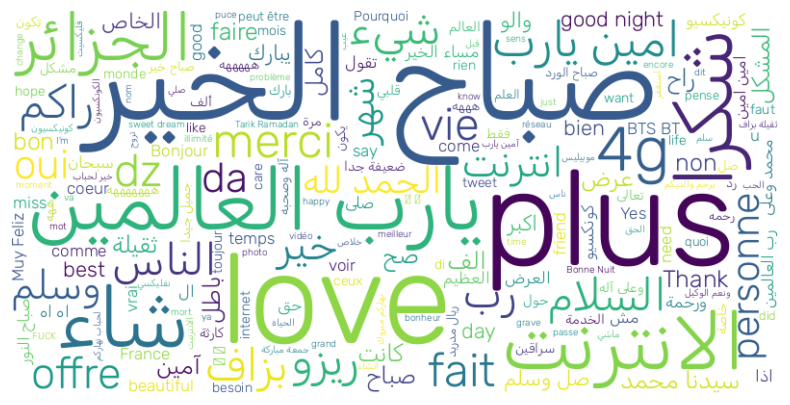

In [ ]:
text = ' '.join(df['Post'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=list(combined_stop_words), font_path='Rubik-VariableFont_wght.ttf').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Machine Learning Model


In [ ]:
#1: Vectorization
vectorizer = TfidfVectorizer(max_features=6000, ngram_range=(1, 2), stop_words=list(combined_stop_words))

In [ ]:
#2: Local testing init
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['Polarity Class'], test_size=0.2, random_state=42)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_model.fit(X_train_tfidf, y_train)

y_pred = mlp_model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8625914315569488
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85      1893
           1       0.82      0.93      0.87      1935

    accuracy                           0.86      3828
   macro avg       0.87      0.86      0.86      3828
weighted avg       0.87      0.86      0.86      3828



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(max_iter=300, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search_mlp = GridSearchCV(mlp_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_mlp.fit(X_train_tfidf, y_train)

print("Best parameters found for MLP:", grid_search_mlp.best_params_)
print("Best cross-validation accuracy:", grid_search_mlp.best_score_)

best_mlp_model = grid_search_mlp.best_estimator_
best_mlp_model.fit(X_train_tfidf, y_train)

y_pred = best_mlp_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found for MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150, 100), 'solver': 'adam'}
Best cross-validation accuracy: 0.8488470834149847
Accuracy: 0.8727795193312434
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86      1893
           1       0.84      0.93      0.88      1935

    accuracy                           0.87      3828
   macro avg       0.88      0.87      0.87      3828
weighted avg       0.88      0.87      0.87      3828



In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_tfidf, y_train)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy:", grid_search_xgb.best_score_)

best_xgb_model = grid_search_xgb.best_estimator_
best_xgb_model.fit(X_train_tfidf, y_train)

y_pred_xgb = best_xgb_model.predict(X_test_tfidf)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation accuracy: 0.7231693774903651


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:03:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7405956112852664
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.53      0.67      1893
           1       0.67      0.94      0.79      1935

    accuracy                           0.74      3828
   macro avg       0.79      0.74      0.73      3828
weighted avg       0.79      0.74      0.73      3828



# Saving the model

In [ ]:
import joblib

# first MLP model
joblib.dump(mlp_model, 'mlp_model.pkl')

# best MLP model
joblib.dump(best_mlp_model, 'best_mlp_model.pkl')

# best XGBoost model
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')



['best_xgb_model.pkl']

# For testing new inputs

In [ ]:
def classify_user_input_with_confidence():
    user_input = input("Enter a comment: ")

    user_input_tfidf = vectorizer.transform([user_input])

    prediction = best_mlp_model.predict(user_input_tfidf)
    confidence = best_mlp_model.predict_proba(user_input_tfidf)

    if prediction == 0:
        sentiment = "Negative"
    else:
        sentiment = "Positive"

    confidence_score = max(confidence[0])
    print(f"The sentiment is: {sentiment} with confidence score: {confidence_score:.2f}")

classify_user_input_with_confidence()


KeyboardInterrupt: Interrupted by user